# Net Surplus Value

Goals:

1. Use veteran contract data to determine the value of each player based on 2024 "performance," which is estimated by madden ratings.
2. Calculate surplus value of each player using LOOCV for each of the 32 teams
3. Compare the sum of surplus value of each position group of each team to estimate largest "areas of need" based on surplus value
 
Data Science Methods:
1. KNN regression to get approx player value based on 2024 performance estimates

Areas of potential bias:
1. Veteran contracts have high variance in APY earnings based on which year the contract was signed. QB contracts are especially vulnerable to skewed correlations of performance to APY
2. 2024 madden ratings do not consider 2025 rookies. NFL teams have funds allocated for these rookies, so 100% of the salary cap is not considered in these plots.

In [28]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

# Load data and combine into single dataframe

In [30]:
player_salaries = pd.read_csv('../data/full_player_salaries.csv')
madden_ratings = pd.read_csv('../data/full_madden_ratings.csv')
combine_data = pd.read_csv('../data/full_combine_data.csv')

player_value_df_raw = player_salaries.merge(madden_ratings, on = 'player_id', how = 'outer')
player_value_df = player_value_df_raw[player_value_df_raw['APY']!=0].dropna().reset_index(drop=1)
player_value_df['log_APY'] = np.log10(player_value_df['APY'] + 1)

# EDA: plot distributions of APY by position group

In [32]:
player_value_df_with_dummies = pd.get_dummies(player_value_df, columns = ['rolled_up_pos_y']).rename(columns={'rolled_up_pos_x':'rolled_up_pos'})

Text(0, 0.5, 'APY')

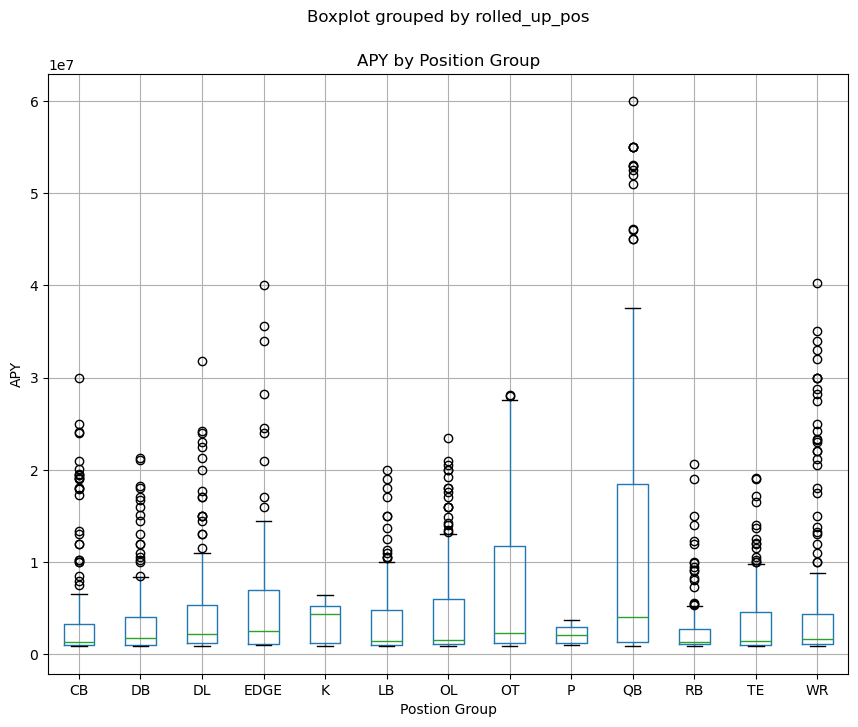

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
player_value_df_with_dummies.boxplot(column=['APY'], by='rolled_up_pos', ax=ax)
plt.title('APY by Position Group')
plt.xlabel('Postion Group')
plt.ylabel('APY')

Text(0, 0.5, 'log_10(APY)')

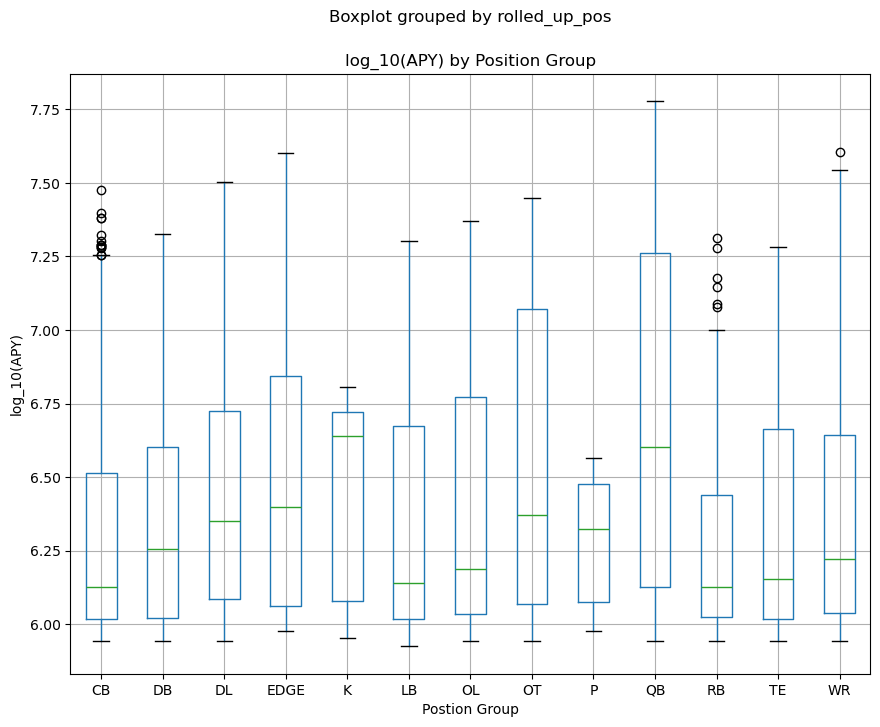

In [40]:
fig, ax = plt.subplots(figsize=(10,8))
player_value_df_with_dummies.boxplot(column=['log_APY'], by='rolled_up_pos', ax=ax)
plt.title('log_10(APY) by Position Group')
plt.xlabel('Postion Group')
plt.ylabel('log_10(APY)')

# KNN regression for player value estimation

## For each team, train a KNN regressor on the remaining 31 teams to predict the player value of players on the holdout team.

Note: train/val/test split for K optimization omitted for the sake of time given that this is a proof of concept approach and that a sub-optimal k is less signifacant than the missing rookie performance estimates and the use of madden ratings as opposed to more robust performance data 

In [42]:
player_value_modeling_df = player_value_df[['OVR', 'SPD', 'STR', 'AGI', 'COD', 'INJ', 'AWR', 'rolled_up_pos_y', 'log_APY', 'APY', 'Team25', 'player_id']].set_index('player_id')

In [44]:
# Function to get the net surplus value for a position group on a given team
def get_nsv(data, team, pos):
    """
    Get the net surplus value for a position group on a given team
    Inputs:
        data (DF) - player_value_modeling_df
        team (str) - team of interest
        pos (str) - position group of interest

    Outputs:
        pos_svs (DF) - The surplus value estimate for each player in the position group
    
    """
    
    X_train = data[
        (data['rolled_up_pos_y']==pos) &
        (data['Team25']!=team)
    ].drop(columns = ['rolled_up_pos_y', 'Team25', 'log_APY', 'APY'])
    
    y_train = data[
        (data['rolled_up_pos_y']==pos) &
        (data['Team25']!=team)
    ]['APY']
    
    X_test = data[
        (data['rolled_up_pos_y']==pos) &
        (data['Team25']==team)
    ].drop(columns = ['rolled_up_pos_y', 'Team25', 'log_APY', 'APY'])
    
    y_test = data[
        (data['rolled_up_pos_y']==pos) &
        (data['Team25']==team)
    ]['APY']

    if len(X_test) > 0:
        # Create and train the KNN regressor
        knn_regressor = KNeighborsRegressor(n_neighbors=5)
        knn_regressor.fit(X_train, y_train)
    
        # Make predictions on the test data
        y_pred = knn_regressor.predict(X_test)
    
        # Get SV for each player in this position
        pos_svs = pd.DataFrame(y_pred - y_test).reset_index().rename(columns = {'APY':'Surplus_Value'})
        pos_svs['Team'] = [team]*len(X_test)
        pos_svs['Postion_Group'] = [pos]*len(X_test)
        pos_svs = pos_svs[['player_id', 'Team', 'Postion_Group', 'Surplus_Value']]
    
    else:
        pos_svs = pd.DataFrame(columns = ['player_id', 'Team', 'Postion_Group', 'Surplus_Value'])

    return(pos_svs)

In [46]:
# For each team and each position group, 
teams = player_value_df.Team25.unique()
positions = player_value_df.rolled_up_pos_y.unique()

league_NSV_df = pd.DataFrame(columns = ['player_id', 'Team', 'Postion_Group', 'Surplus_Value'])

for team in teams:
    for pos in positions:
        temp = get_nsv(player_value_modeling_df, team, pos)
        if len(temp) > 0:
            league_NSV_df = pd.concat([league_NSV_df, temp])


/var/folders/6q/12np3cbs1dq2rljpcqv49bc00000gn/T/ipykernel_65686/228751666.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  league_NSV_df = pd.concat([league_NSV_df, temp])


## league_NSV_df contains the net surplus value for each position group for each team

In [60]:
league_NSV_df.groupby(['Team', 'Postion_Group']).sum('Surplus_Value')

Surplus_Value
Team    Postion_Group               
49ers   CB                -6438546.6
        DB                 -318665.6
        DL                  208803.6
        EDGE             -13241851.0
        K                  1227398.4
...                              ...
Vikings P                   532895.0
        QB                10344869.0
        RB                -7533170.0
        TE                -7022723.2
        WR                 3152588.6

[400 rows x 1 columns]

In [63]:
def plot_areas_of_need(team):
    """
    Plot the NSV to show areas of need for a given team
    
    Inputs:
        team (str) - team of interest

    Outputs:
        visualization
    
    """

    nsv_data = league_NSV_df[
    (league_NSV_df['Team']==team) #& 
    #(league_NSV_df['Postion_Group']!='QB') # include this if you wish to exclude QBs
    ].groupby('Postion_Group').sum('Surplus_Value').reset_index()
    
    colors = nsv_data['Surplus_Value'].apply(lambda x: 'green' if x >= 0 else 'red')

    plt.figure(figsize=(10, 6))
    bars = plt.bar(nsv_data['Postion_Group'], nsv_data['Surplus_Value'], color=colors)
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + (0.5 if height >= 0 else -0.5),
            f'{height:.1f}',
            ha='center',
            va='bottom' if height >= 0 else 'top',
            fontsize=10
        )
        
    plt.axhline(0, color='black')
    
    plt.xlabel('Postion Group')
    plt.ylabel('Net Surplus Value')
    plt.title(f'{team} "Areas of Need"')
    plt.tight_layout()
    plt.show()

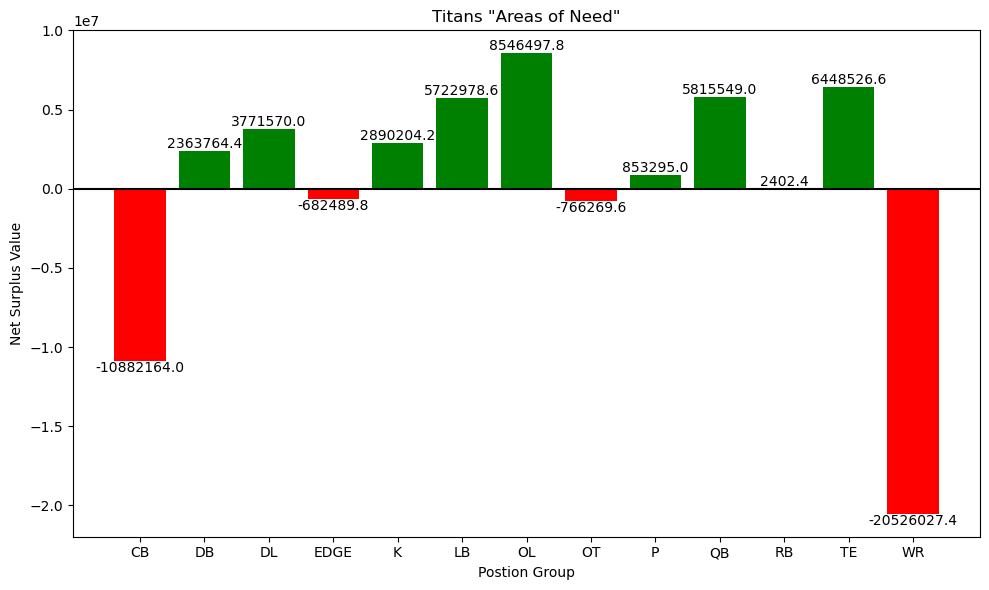

In [56]:
plot_areas_of_need('Titans')

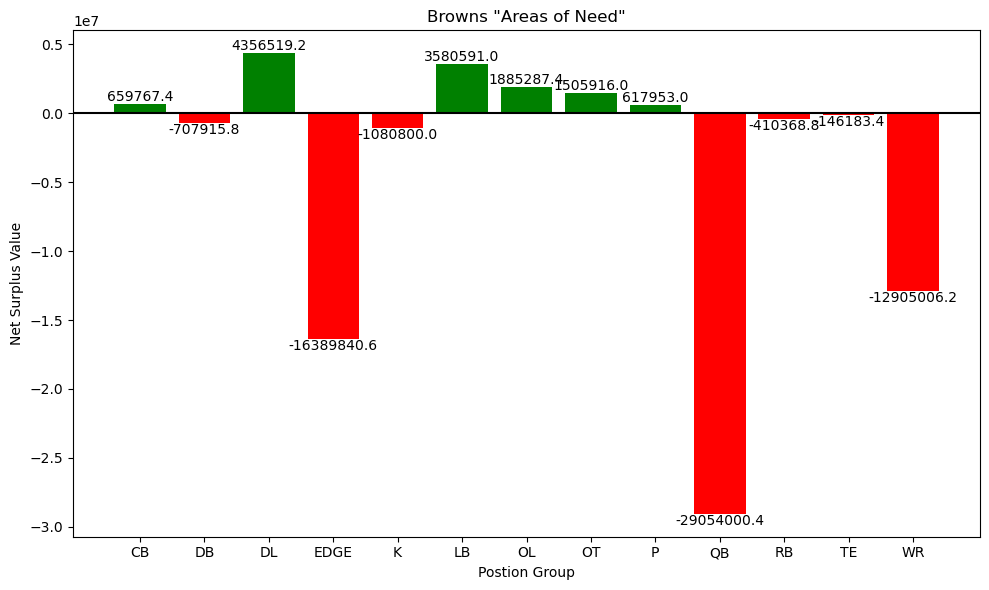

In [67]:
plot_areas_of_need('Browns')

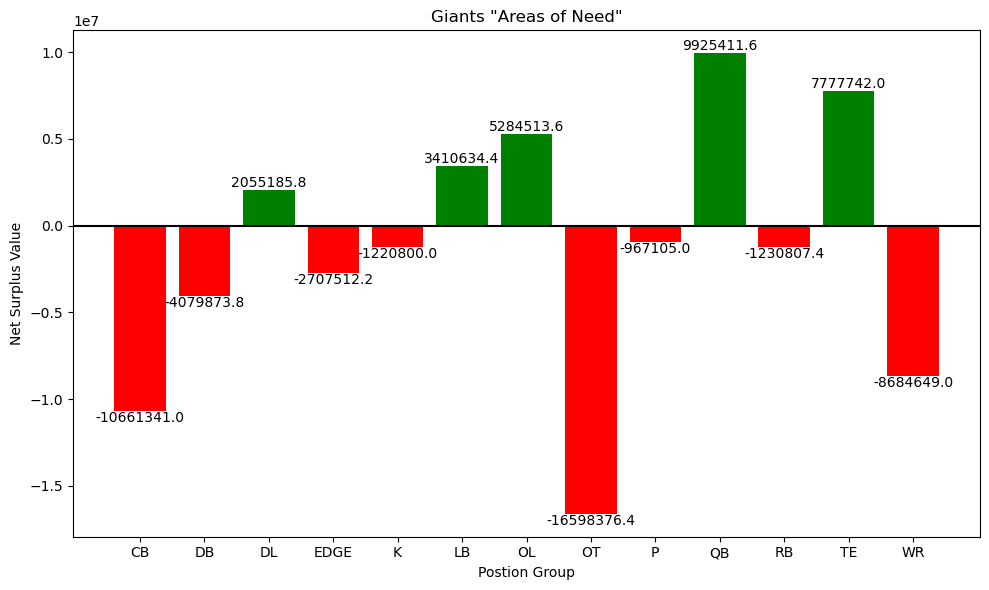

In [72]:
plot_areas_of_need('Giants')

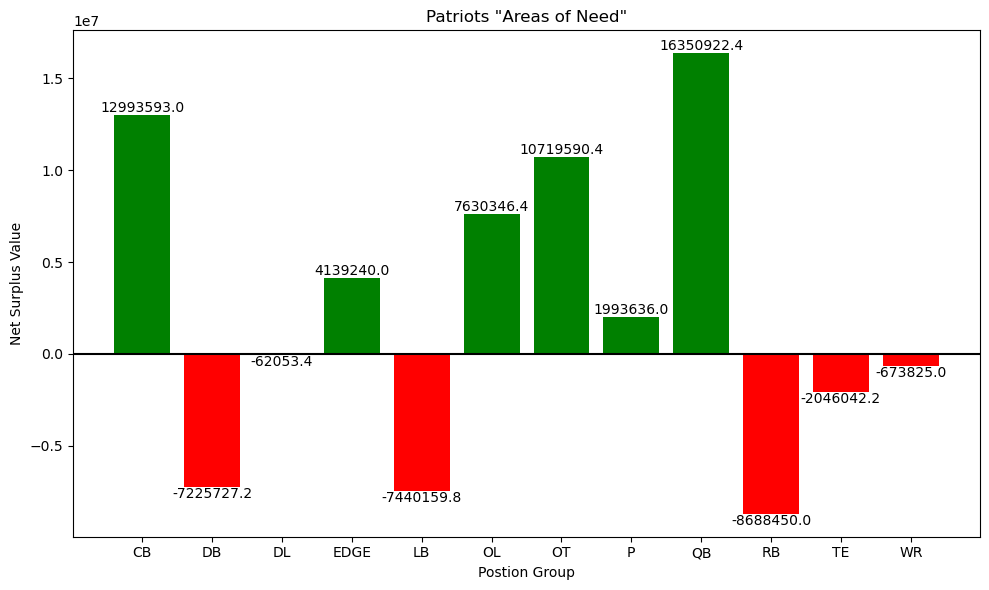

In [76]:
plot_areas_of_need('Patriots')

In [54]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

In [69]:
league_NSV_df[
    league_NSV_df['Team']=='Bengals'
].groupby(
    ['Team', 'Postion_Group']
).sum(
    'Surplus_Value'
).style.bar(
    align='mid', 
    color=['#d65f5f', '#5fba7d']
)